### Pre-processing: Data Understanding
1. Import Libraries 

In [506]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
import xgboost as xgb

# Modelling Helpers
from sklearn.preprocessing import  Normalizer , scale, LabelEncoder
from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.model_selection import train_test_split , StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel
from time import time
from sklearn.metrics import f1_score

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from IPython.display import display

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

# poisson model
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools

In [507]:
row_2017 = pd.read_csv('./data/2017session.csv')
row_2018 = pd.read_csv('./data/2018session.csv')
row_2019 = pd.read_csv('./data/2019session.csv')
row_2020 = pd.read_csv('./data/2020session.csv')
row_2021 = pd.read_csv('./data/2021session.csv')
row_list = [row_2017, row_2018, row_2019, row_2020, row_2021]
# shpe of all data
print ('Datasets:' , 'Row:' , row_2017.shape)
print(row_2017.shape)
print(row_2018.shape)
print(row_2019.shape)
print(row_2020.shape)
print(row_2021.shape)
#row_2017.head()
#print ('Datasets:' , 'lables:' , row_2017.columns.values)
#print ('Datasets:' , 'lables:' , row_2018.columns.values)
#print ('Datasets:' , 'lables:' , row_2019.columns.values)
#print ('Datasets:' , 'lables:' , row_2020.columns.values)
#print ('Datasets:' , 'lables:' , row_2021.columns.values)

Datasets: Row: (306, 65)
(306, 65)
(306, 62)
(306, 106)
(306, 106)
(306, 106)


In [508]:
# select initial features

columns_req = ['HomeTeam','AwayTeam','FTHG','FTAG','FTR','Session']

statistics_2017 = row_2017[columns_req]
statistics_2018 = row_2018[columns_req]
statistics_2019 = row_2019[columns_req]
statistics_2020 = row_2020[columns_req]
statistics_2021 = row_2021[columns_req]

In [509]:
''' 
In Bundeslig matches in a year:
306 matches 
34 'Spieltag'(week)
9 matches one week (full 18 teams in matching)

This sector create 2 new fratures
 HTGD: Home team goals cumulate
 ATGD: Away team goals cumulate
'''
# Calculate the cumulative goals per team per week
def get_goals_cumulate(playing_stat):
    # Create a dictionary, teams name as 'Key', teams(18*34)
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []
    # for every matches
    for i in range(len(playing_stat)):
        # full time goals for home team
        HTGC = playing_stat.iloc[i]['FTHG']
        # full time goals for away team
        ATGC = playing_stat.iloc[i]['FTAG']

        # add cumulative goals to home teams
        teams[playing_stat.iloc[i].HomeTeam].append(HTGC)
        # add cumulative goals to away teams
        teams[playing_stat.iloc[i].AwayTeam].append(ATGC)
    

    # rows as team-names, columns as matchweek
    GoalsCumulate = pd.DataFrame(data=teams, index = [i for i in range(1,35)]).T
    GoalsCumulate[0] = 0
    # colmulate goals by weeks
    for i in range(2,35):
        GoalsCumulate[i] = GoalsCumulate[i] + GoalsCumulate[i-1]    
    return GoalsCumulate
    

def get_gc(playing_stat):

    # get statistic of goals cumulate
    GD = get_goals_cumulate(playing_stat)

    j = 0
    #  creat new features: goals cumulate for home team and away team
    HTGC = []
    ATGC = []

    # total 306 matches in whole year
    for i in range(306):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam

        HTGC.append(GD.loc[ht][j])
        ATGC.append(GD.loc[at][j])

        if ((i + 1)% 9) == 0:
            j = j + 1

    # add new created HTGC ATGDC features to dataframe
    playing_stat.loc[:,'HTGC'] = HTGC
    playing_stat.loc[:,'ATGC'] = ATGC

    return playing_stat

statistics_2017 = get_gc(statistics_2017)
statistics_2018 = get_gc(statistics_2018)
statistics_2019 = get_gc(statistics_2019)
statistics_2020 = get_gc(statistics_2020)
statistics_2021 = get_gc(statistics_2021)



In [510]:
''' 
This sector create 2 new fratures
 HTGD: Home team goals difference
 ATGD: Away team goals difference
'''
# Calculate the cumulative goal difference per team per week
def get_goals_diff(playing_stat):
    # Create a dictionary, teams name as 'Key', teams(18*34)
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []
    # for every matches
    for i in range(len(playing_stat)):
        # full time goals for home team
        HTGS = playing_stat.iloc[i]['FTHG']
        # full time goals for away team
        ATGS = playing_stat.iloc[i]['FTAG']

        # add cumulative goal difference to home teams
        teams[playing_stat.iloc[i].HomeTeam].append(HTGS-ATGS)
        # add cumulative goal difference to away teams
        teams[playing_stat.iloc[i].AwayTeam].append(ATGS-HTGS)
    

    # rows as team-names, columns as matchweek
    GoalsDifference = pd.DataFrame(data=teams, index = [i for i in range(1,35)]).T
    GoalsDifference[0] = 0
    # colmulate goal difference by weeks
    for i in range(2,35):
        GoalsDifference[i] = GoalsDifference[i] + GoalsDifference[i-1]    
    return GoalsDifference
    

def get_gss(playing_stat):

    # get statistic of goals difference
    GD = get_goals_diff(playing_stat)

    j = 0
    #  creat new features: clear goals difference for home team and away team
    HTGD = []
    ATGD = []

    # total 306 matches in whole year
    for i in range(306):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam

        HTGD.append(GD.loc[ht][j])
        ATGD.append(GD.loc[at][j])

        if ((i + 1)% 9) == 0:
            j = j + 1

    # add new created HTGD ATGD features to dataframe
    playing_stat.loc[:,'HTGD'] = HTGD
    playing_stat.loc[:,'ATGD'] = ATGD

    return playing_stat

statistics_2017 = get_gss(statistics_2017)
statistics_2018 = get_gss(statistics_2018)
statistics_2019 = get_gss(statistics_2019)
statistics_2020 = get_gss(statistics_2020)
statistics_2021 = get_gss(statistics_2021)



In [511]:
# add feature: in which week(Spieltag)
def get_mw(playing_stat):
    j = 1
    MatchWeek = []
    for i in range(306):
        MatchWeek.append(j)
        if ((i + 1)% 9) == 0:
            j = j + 1
    playing_stat['MW'] = MatchWeek
    return playing_stat

statistics_2017 = get_mw(statistics_2017)
statistics_2018 = get_mw(statistics_2018)
statistics_2019 = get_mw(statistics_2019)
statistics_2020 = get_mw(statistics_2020)
statistics_2021 = get_mw(statistics_2021)

In [512]:
#combine data from 'n' years
playing_stat = pd.concat([statistics_2017,
                          statistics_2018,
                          statistics_2019,
                          statistics_2020,
                          statistics_2021
                          ], ignore_index=True)

#get mean value: HTGD, ATGD ,HTP, ATP divided by 'week'
cols = ['HTGC','ATGC','HTGD','ATGD']
playing_stat.MW = playing_stat.MW.astype(float)
for col in cols:
    playing_stat[col] = playing_stat[col] / playing_stat.MW


In [513]:
''' 
This sector create 2 new fratures
 (H/A)GDD: difference of "goals diff" from away and home
 (H/A)GCD: difference of "goals cumu" from away and home
'''
## calculate difference of cumulative goals and difference goals, for the purpose of seperate features later

for i in range(len(playing_stat)):
    playing_stat.loc[i, 'HGCD'] = playing_stat.iloc[i]['HTGC'] - playing_stat.iloc[i]['ATGC']
    playing_stat.loc[i, 'HGDD'] = playing_stat.iloc[i]['HTGD'] - playing_stat.iloc[i]['ATGD']
    
    playing_stat.loc[i, 'AGCD'] = playing_stat.iloc[i]['ATGC'] - playing_stat.iloc[i]['HTGC']
    playing_stat.loc[i, 'AGDD'] = playing_stat.iloc[i]['ATGD'] - playing_stat.iloc[i]['HTGD']

# chose dataset after the 3. match
#playing_stat = playing_stat[playing_stat.MW > 3]


In [514]:
# print features ready to train the model
playing_stat.keys()
playing_stat.head()
playing_stat.to_csv('../intermediate/pre_poisson.csv')


In [515]:
# number of matches
n_matches = playing_stat.shape[0]

# number of features
n_features = playing_stat.shape[1] - 1

# number of wins from home team
n_homewins = len(playing_stat[playing_stat.FTR == 'H'])

# win-rate from home team
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print("number of matches: {}".format(n_matches))
print("number of features: {}".format(n_features))
print("number of wins from home team: {}".format(n_homewins))
print("win-rate from home team: {:.2f}%".format(win_rate))

number of matches: 1530
number of features: 14
number of wins from home team: 672
win-rate from home team: 43.92%


In [516]:
# create two dataframe for the home and away teams
home = playing_stat[['HomeTeam', 'FTHG']].rename(columns={'HomeTeam':'team', 'FTHG':'score'})
away = playing_stat[['AwayTeam', 'FTAG']].rename(columns={'AwayTeam':'team', 'FTAG':'score'})
# merge it into one
team_score = home.append(away).reset_index(drop=True)
team_score = team_score.groupby('team')['score'].agg(['sum','count','mean']).reset_index()
team_score = team_score.rename(columns={'sum':'nb_goals', 'count':'nb_matches', 'mean':'goal_avg'})
team_score.head()

,team,nb_goals,nb_matches,goal_avg
0,Augsburg,214,170,1.258824
1,Bayern Munich,476,170,2.800000
2,Bielefeld,53,68,0.779412
3,Bochum,38,34,1.117647
4,Dortmund,389,170,2.288235


In [517]:
"""
plt.figure(figsize = (15,10))
sns.set_style("whitegrid")
plt_data = team_score.sort_values(by='goal_avg', ascending=False)[:10]
ax = sns.barplot(x="team", y="goal_avg", data=plt_data, palette="Blues_r")
ax.set_xlabel('Team', size=16)
ax.set_ylabel('Goal average per match', size=16)
ax.set_title("TOP 10 OF GOAL AVERAGE PER MATCH", fontsize=18)
"""

'\nplt.figure(figsize = (15,10))\nsns.set_style("whitegrid")\nplt_data = team_score.sort_values(by=\'goal_avg\', ascending=False)[:10]\nax = sns.barplot(x="team", y="goal_avg", data=plt_data, palette="Blues_r")\nax.set_xlabel(\'Team\', size=16)\nax.set_ylabel(\'Goal average per match\', size=16)\nax.set_title("TOP 10 OF GOAL AVERAGE PER MATCH", fontsize=18)\n'

In [518]:
means = playing_stat[['FTHG','FTAG']].mean()
print(means['FTHG'])

1.6980392156862745


In [519]:
"""
plt.figure(figsize=(15,10))
sns.set_style("white")
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(k, means[j]) for k in range(10)] for j in range(2)])
# plot histogram of actual goals
plt.hist(playing_stat[['FTHG', 'FTAG']].values, range(11), alpha=0.8,
         label=['Home', 'Away'], density=True, color=["#3498db", "#e74c3c"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#2980b9')
pois2, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#c0392b')

leg=plt.legend(loc='upper right', fontsize=16, ncol=2)
leg.set_title("Poisson        Actual      ", prop = {'size':'18', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,11)],[i for i in range(10)])
plt.xlabel("Goals per Match",size=18)
plt.ylabel("Proportion of Matches",size=18)
plt.title("Number of Goals per Match",size=20,fontweight='bold')
plt.show()
"""

'\nplt.figure(figsize=(15,10))\nsns.set_style("white")\n# construct Poisson  for each mean goals value\npoisson_pred = np.column_stack([[poisson.pmf(k, means[j]) for k in range(10)] for j in range(2)])\n# plot histogram of actual goals\nplt.hist(playing_stat[[\'FTHG\', \'FTAG\']].values, range(11), alpha=0.8,\n         label=[\'Home\', \'Away\'], density=True, color=["#3498db", "#e74c3c"])\n\n# add lines for the Poisson distributions\npois1, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred[:,0],\n                  linestyle=\'-\', marker=\'o\',label="Home", color = \'#2980b9\')\npois2, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred[:,1],\n                  linestyle=\'-\', marker=\'o\',label="Away", color = \'#c0392b\')\n\nleg=plt.legend(loc=\'upper right\', fontsize=16, ncol=2)\nleg.set_title("Poisson        Actual      ", prop = {\'size\':\'18\', \'weight\':\'bold\'})\n\nplt.xticks([i-0.5 for i in range(1,11)],[i for i in range(10)])\nplt.xlabel("Goals per Match",size=18)

In [520]:
home_matches = playing_stat[['FTHG','HTGC','HTGD','Session','MW','HomeTeam','HGDD','HGCD' ]].rename(columns={'HomeTeam':'team','FTHG':'goal','HTGC':'goal_cum', 'HTGD':'goal_diff', 'HGDD':'GDD','HGCD':'GCD'})
home_matches['H_or_A'] = 1.698039
away_matches = playing_stat[['FTAG','ATGC','ATGD','Session','MW','AwayTeam','AGDD','AGCD']].rename(columns={'AwayTeam':'team','FTAG':'goal','ATGC':'goal_cum', 'ATGD':'goal_diff','AGDD':'GDD','AGCD':'GCD'})
away_matches['H_or_A'] = 1.368627

matches_model_data = pd.concat([home_matches, away_matches])
#matches_model_data = matches_model_data[playing_stat.MW > 2]
matches_model_data.to_csv('../intermediate/data_poisson.csv')
X = matches_model_data.drop(columns=['MW', 'goal','team','Session'])
#X2 = matches_model_data.drop(columns=['MW'])
y = matches_model_data['goal']

In [521]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Features'] = X.columns
vif

,VIF Factor,Features
0,16.044484,goal_cum
1,3.684141,goal_diff
2,6.207818,GDD
3,5.533922,GCD
4,14.051735,H_or_A


In [535]:
# divide datatset into train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state = 2, stratify = y)
X_train.head()


,goal_cum,goal_diff,GDD,GCD,H_or_A
1018,1.583333,-0.083333,1.000000,0.583333,1.698039
928,1.500000,1.000000,-0.500000,0.000000,1.698039
1243,1.666667,1.333333,2.666667,1.666667,1.368627
958,1.400000,0.400000,1.000000,0.400000,1.698039
1316,1.727273,0.363636,1.272727,1.000000,1.368627


In [523]:
X_train = sm.add_constant(X_train) # Adding constant
poisson_reg = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
poisson_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   goal   No. Observations:                 2295
Model:                            GLM   Df Residuals:                     2289
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3522.8
Date:                Tue, 11 Oct 2022   Deviance:                       2671.0
Time:                        10:20:08   Pearson chi2:                 2.37e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1158
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7154      0.175     -4.089      0.000      -1.058      -0.372
goal_cum       0.0839      0.052      1.615      0.106      -0.018       0.186
goal_diff      0.0335      0.042      0.799      0.424      -0.049       0.116
GDD            0.1443      0.036      4.041      0.000       0.074       0.214
GCD            0.0533      0.053      1.004      0.315      -0.051       0.157
H_or_A         0.6434      0.103      6.236      0.000       0.441       0.846
==============================================================================
"""

In [524]:
X_test = sm.add_constant(X_test)
#print(X_test)
poisson_reg_preds = poisson_reg.get_prediction(X_test)
poisson_reg_preds.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper
622,1.460474,0.100376,1.276415,1.671074
1331,1.765565,0.059235,1.653202,1.885565
422,1.334184,0.055189,1.230283,1.446859
68,1.816828,0.059521,1.703836,1.937314
618,1.179631,0.087337,1.020295,1.363851
...,...,...,...,...
363,1.123000,0.043234,1.041381,1.211016
276,1.343134,0.040118,1.266761,1.424112
1250,1.518137,0.074308,1.379264,1.670994
724,2.449923,0.112061,2.239846,2.679704


Text(0.5, 1.0, 'Test Data vs Poisson Regression Predictions')

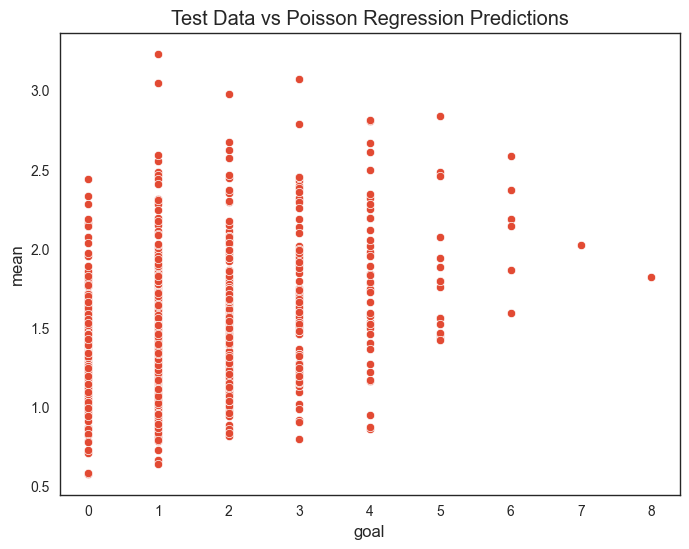

In [525]:
sns.scatterplot(y_test, poisson_reg_preds.summary_frame()['mean'])
plt.title('Test Data vs Poisson Regression Predictions')

Text(0.5, 1.0, 'Residuals')

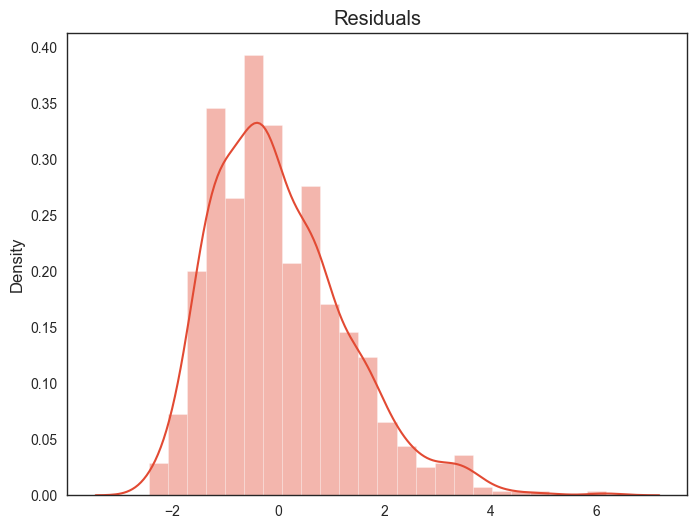

In [526]:
sns.distplot(y_test-poisson_reg_preds.summary_frame()['mean'])
plt.title('Residuals')

In [527]:
def get_proba_match(foot_model, goal_cum_H, goal_cum_A,goal_diff_H, goal_diff_A, HA_H, HA_A, diff_cum_H, diff_diff_H ,diff_cum_A,diff_diff_A):

    # Get the average goal for each team
    t1_goals_avg = foot_model.predict(pd.DataFrame(data={'goal_cum': goal_cum_H, 'goal_diff': goal_diff_H,'H_or_A': HA_H,'GCD':diff_cum_H,'GDD':diff_diff_H,'const':1}, index=[1])).values[0]
    t2_goals_avg = foot_model.predict(pd.DataFrame(data={'goal_cum': goal_cum_A, 'goal_diff': goal_diff_A,'H_or_A': HA_A,'GCD':diff_cum_A,'GDD':diff_diff_A,'const':1}, index=[1])).values[0]
    
    # Get probability of all possible score for each team
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, 11)] for team_avg in [t1_goals_avg, t2_goals_avg]]
    
    # Do the product of the 2 vectors to get the matrix of the match
    match = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    
    # Get the proba for each possible outcome
    t1_wins = np.sum(np.tril(match, -1))
    draw = np.sum(np.diag(match))
    t2_wins = np.sum(np.triu(match, 1))
    result_proba = [t1_wins, draw, t2_wins]
    
    # Adjust the proba to sum to one
    result_proba =  np.array(result_proba)/ np.array(result_proba).sum(axis=0,keepdims=1)
    team_pred[0] = np.array(team_pred[0])/np.array(team_pred[0]).sum(axis=0,keepdims=1)
    team_pred[1] = np.array(team_pred[1])/np.array(team_pred[1]).sum(axis=0,keepdims=1)
    #print(result_proba, [np.array(team_pred[0]), np.array(team_pred[1])])
    return result_proba, [np.array(team_pred[0]), np.array(team_pred[1])]

In [528]:
def get_match_result(foot_model, line_data, elimination=False, max_draw=800, max_goals=10):
    HA_H = means['FTHG']
    HA_A = means['FTAG'] 
    goal_cum_H = line_data['HTGC']
    goal_cum_A = line_data['ATGC']
    goal_diff_H = line_data['HTGD']
    goal_diff_A = line_data['ATGD']# Get the proba
    diff_cum_H = line_data['HGCD']
    diff_diff_H = line_data['HGDD']
    diff_cum_A = line_data['AGCD']
    diff_diff_A = line_data['AGDD']
    team1 = line_data['HomeTeam']
    team2 = line_data['AwayTeam']
    proba, score_proba = get_proba_match(foot_model, goal_cum_H, goal_cum_A,goal_diff_H, goal_diff_A, HA_H, HA_A, diff_cum_H, diff_diff_H, diff_cum_A, diff_diff_A)
    
    # Get the result, if it's an elimination game we have to be sure the result is not draw
    results = pd.Series([np.random.choice([team1, 'draw', team2], p=proba) for i in range(0,max_draw)]).value_counts()
    result = results.index[0]
    #result = results.index[0] if not elimination or (elimination and results.index[0] != 'draw') else results.index[1]
    
    #print(proba, results.index[0],results.index[1],results.index[2],score_proba)
    
    # If the result is not a draw game then we calculate the score of the winner from 1 to the max_goals 
    # and the score of the looser from 0 to the score of the winner
    if (result != 'draw'): 
        i_win, i_loose = (0,1) if result == team1 else (1,0)
        score_proba[i_win] = score_proba[i_win][1:]/score_proba[i_win][1:].sum(axis=0,keepdims=1)
        winner_score = pd.Series([np.random.choice(range(1, max_goals+1), p=score_proba[i_win]) for i in range(0,max_draw)]).value_counts().index[0]
        score_proba[i_loose] = score_proba[i_loose][:winner_score]/score_proba[i_loose][:winner_score].sum(axis=0,keepdims=1)
        looser_score = pd.Series([np.random.choice(range(0, winner_score), p=score_proba[i_loose]) for i in range(0,max_draw)]).value_counts().index[0]
        if result == team1:
            score = [winner_score, looser_score]
        else: score = [looser_score, winner_score]
    # If it's a draw then we calculate a score and repeat it twice
    else:
        score = np.repeat(pd.Series([np.random.choice(range(0, max_goals+1), p=score_proba[0]) for i in range(0,max_draw)]).value_counts().index[0],2)
    looser = team2 if result == team1 else team1 if result != 'draw' else 'draw'
    #print(result, looser, score)
    return result, looser, score

In [529]:
pre_right = 0
#playing_stat = sm.add_constant(playing_stat,has_constant='add')
for i in range(len(playing_stat)):
    c1,c2,c3 = get_match_result(poisson_reg, playing_stat.iloc[i])
    playing_stat.loc[i, 'win_team'] = c1
    playing_stat.loc[i, 'lose_team'] = c2
    playing_stat.loc[i, 'pred_score'] = str(c3)
    if c1 == 'draw':
        playing_stat.loc[i, 'pre_win'] = 'D'
    else:
        if playing_stat.loc[i, 'win_team'] == playing_stat.loc[i, 'HomeTeam']:
            playing_stat.loc[i, 'pre_win'] = 'H'
        elif playing_stat.loc[i, 'win_team'] == playing_stat.loc[i, 'AwayTeam']:
            playing_stat.loc[i, 'pre_win'] = 'A'
        else: playing_stat.loc[i, 'pre_win'] = 'FALSE'
        
    if playing_stat.loc[i, 'pre_win'] == playing_stat.loc[i, 'FTR']:
        pre_right += 1
actural = dict(playing_stat['FTR'].value_counts())
act_H = actural['H']
act_D = actural['D'] 
act_A = actural['A']     
pre_acc = pre_right/len(playing_stat)
recall_H = pre_right/act_H
print('prediction accuracy on whole dataset is ', pre_acc )
print('reacall of H is ', recall_H )
print(f'act_H is {act_H}, act_D is {act_D},act_A is {act_A} ')
#playing_stat.head(150)
playing_stat.to_csv('../intermediate/poisson_output.csv')

prediction accuracy on whole dataset is  0.30196078431372547
reacall of H is  0.6875
act_H is 672, act_D is 378,act_A is 480 


In [530]:

def train_classifier(clf, X_train, y_train):
    ''' train model '''

    # record train time
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    print("train time {:.4f} sec".format(end - start))

def predict_labels(clf, features, target):
    ''' predict results with trained model '''

    # record predict time
    start = time()
    y_pred = clf.predict(features)
    end = time()

    print("predict time in {:.4f} sec".format(end - start))
    return f1_score(target, y_pred, average='micro'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' train and evaluate models:'''

    # train model 
    print('train model of : {}, ，number of samples: {}'.format(clf.__class__.__name__,len(X_train)))
    train_classifier(clf, X_train, y_train)
    
    # evaluate model on train/test dataset
    f1, acc = predict_labels(clf, X_train, y_train)
    print("On train dataset: F1 score and accuracy are {:.4f} , {:.4f}.".format(f1 , acc))

    f1, acc = predict_labels(clf, X_test, y_test)
    print("On test dataset: F1 score and accuracy are: {:.4f} , {:.4f}.".format(f1 , acc))


In [531]:

#Random Forests Model
model_rf = RandomForestClassifier(n_estimators=50)

#XGBoosting Model
model_XGB = xgb.XGBClassifier(seed = 42)

#Gradient Boosting Classifier
model_gboost = GradientBoostingClassifier()

models = [model_rf, model_XGB, model_gboost]

for model in models:
    train_predict(clf=model, X_train=X_train, y_train=y_train,  X_test=X_test, y_test=y_test )
    print('****')


train model of : RandomForestClassifier, ，number of samples: 2295
train time 0.1858 sec
predict time in 0.0256 sec
On train dataset: F1 score and accuracy are 0.9813 , 0.9813.
predict time in 0.0144 sec
On test dataset: F1 score and accuracy are: 0.2758 , 0.2758.
****
train model of : XGBClassifier, ，number of samples: 2295
train time 1.5330 sec
predict time in 0.0080 sec
On train dataset: F1 score and accuracy are 0.9590 , 0.9590.
predict time in 0.0041 sec
On test dataset: F1 score and accuracy are: 0.2850 , 0.2850.
****
train model of : GradientBoostingClassifier, ，number of samples: 2295
train time 2.5928 sec
predict time in 0.0219 sec
On train dataset: F1 score and accuracy are 0.6253 , 0.6253.
predict time in 0.0071 sec
On test dataset: F1 score and accuracy are: 0.2915 , 0.2915.
****


In [539]:
# turn run_gs to True to run gridsearch again.
run_gs = True

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [100,300,500,1000],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [3, 10, 20],
                 'min_samples_leaf': [ 3, 10, 20],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(X_train, y_train)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(X_train, y_train)
    

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best score: 0.33289760348583874
Best parameters: {'bootstrap': False, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}


In [557]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels.values)
    #mape = errors/test_labels.values
    #mape = 100 * np.mean(errors/test_labels.values)
    #print(mape)
    #accuracy = 100 - mape 
    erro = np.mean(errors)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(erro))
    #print('Accuracy = {:0.2f}%.'.format(accuracy))
    return erro

base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_erro = evaluate(base_model, X_test, y_test)

best_random = model.best_estimator_
random_erro  = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( -100 * (random_erro - base_erro) / base_erro))

Model Performance
Average Error: 1.1935 degrees.
Model Performance
Average Error: 0.9961 degrees.
Improvement of 16.54%.


In [542]:
pre_right_rf = 0
def get_pre_rf(model, line_data):
    HA_H = means['FTHG']
    HA_A = means['FTAG'] 
    goal_cum_H = line_data['HTGC']
    goal_cum_A = line_data['ATGC']
    goal_diff_H = line_data['HTGD']
    goal_diff_A = line_data['ATGD']# Get the proba
    diff_cum_H = line_data['HGCD']
    diff_diff_H = line_data['HGDD']
    diff_cum_A = line_data['AGCD']
    diff_diff_A = line_data['AGDD']
    team1 = line_data['HomeTeam']
    team2 = line_data['AwayTeam']
    H_goals_pre = model.predict(pd.DataFrame(data={'goal_cum': goal_cum_H, 'goal_diff': goal_diff_H,'H_or_A': HA_H,'GCD':diff_cum_H,'GDD':diff_diff_H}, index=[1]))
    A_goals_pre = model.predict(pd.DataFrame(data={'goal_cum': goal_cum_A, 'goal_diff': goal_diff_A,'H_or_A': HA_A,'GCD':diff_cum_A,'GDD':diff_diff_A}, index=[1]))
    return H_goals_pre,A_goals_pre
    
for i in range(len(playing_stat)):
    g1,g2 = get_pre_rf(model, playing_stat.iloc[i])
    playing_stat.loc[i, 'pre_rf_goal_H'] = g1
    playing_stat.loc[i, 'pre_rf_goal_A'] = g2
    if g1 > g2:
        playing_stat.loc[i, 'pre_rf_win'] = 'H'
    elif g2 > g1:
        playing_stat.loc[i, 'pre_rf_win'] = 'A'
    else: playing_stat.loc[i, 'pre_rf_win'] = 'D'
    if playing_stat.loc[i, 'pre_rf_win'] == playing_stat.loc[i, 'FTR']:
        pre_right_rf += 1
    
pre_acc_rf = pre_right_rf/len(playing_stat)
recall_H_rf = pre_right/act_H
print('prediction accuracy on whole dataset with rf is ', pre_acc_rf )
print('reacall of H is ', recall_H_rf )
playing_stat.to_csv('../intermediate/rf_output.csv')

prediction accuracy on whole dataset with rf is  0.330718954248366
reacall of H is  0.6875
